# Wine Quaity DataSet Classification


## Data Set Information:

* Source: https://www.kaggle.com/rajyellow46/wine-quality

The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

## Data Set Information:

* For more information, read [Cortez et al., 2009].

### Input variables (based on physicochemical tests):
1 - fixed acidity  
2 - volatile acidity  
3 - citric acid  
4 - residual sugar  
5 - chlorides  
6 - free sulfur dioxide   
7 - total sulfur dioxide  
8 - density   
9 - pH  
10 - sulphates  
11 - alcohol 

### Output variable (based on sensory data):
12 - quality (score between 0 and 10)

Acknowledgements:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

# The summary of analysis:


## Aim/Purpose

* The idea is create a machine learning model to:
    - Data Exploration/Visualization
        - Understand structure of the data.
    - Predict the quality of wine based on 11 inputs.
    - Determine factors which have the higher probability to predict the quality.
        - Reduce the dimension of variables. (Feature engineering)
    - Determine machine learning model for best classifying the wines.
    
    
## The flaw of analysis:

* We missed out problem dealing with imbalanced class.
    - There's more normal quality wines than poor/exellent ones.
    - Can be done with SMOTE (Synthetic Minority Oversampling Technique)
    - Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
    - Add in another algorithm to oversample minority classs by duplication.

## Data Exploration:

* The charts are in the notebook.
* Found mainly three variables affecting the result of predicting outcomes:
    - Alcohol (Positive correlation with quality)
    - Volatile Acidity (Negaitve correlation with quality)
    

## Model:

* We used **XGboost algorithm**.
* Also we tried out several different algorithm such as CART and random forest.
* Reference: https://xgboost.readthedocs.io/en/latest/tutorials/model.html
* Advantages include:
    * Regularization.    
    * Parallel Processing:
    * High Flexibility
    * Handling Missing Values
    * Tree Pruning:
        * A GBM would stop splitting a node when it encounters a negative loss in the split. 
        * XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.  
    * Built-in Cross-Validation  

In [1]:
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb


%reload_ext watermark
%watermark -v -p numpy,pandas,scikit-learn

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy       : 1.19.2
pandas      : 1.2.0
scikit-learn: 0.24.1



# Load the Dataset

In [2]:
dr_workplace = 'C:\\Users\\user\\Documents\\winequality\\'
df = pd.read_csv(dr_workplace + 'winequalityN.csv') # Load the data

# Check Countplot per Quality

* The dataset is highly imbalanced.

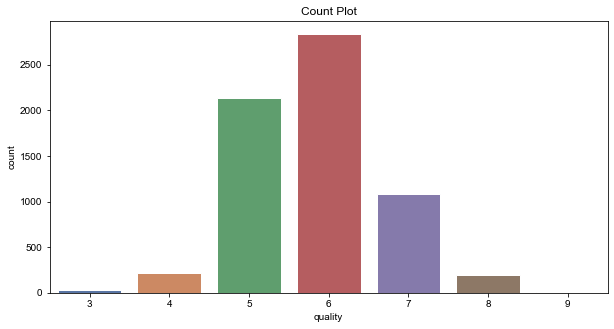

In [3]:
f, axes = plt.subplots(1, 1, figsize = (10, 5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="quality", data = df).set_title('Count Plot')

# Reclassification of Quality

* This is to ease the classification problem, as we want to have a trial only.
* We further classify the wine to **three-class**.
    - 3 - 5:: Low
    - 6: Medium
    - 7 - 9: High 

In [4]:
df['quality_label'] = df.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q == 6 else 'high')
class_ql = {'low':0, 'medium': 1, 'high': 2}

* The count plot looks better now, more or less.
* Minority samples are still an issue, we can use SMOTE to oversample the training dataset.

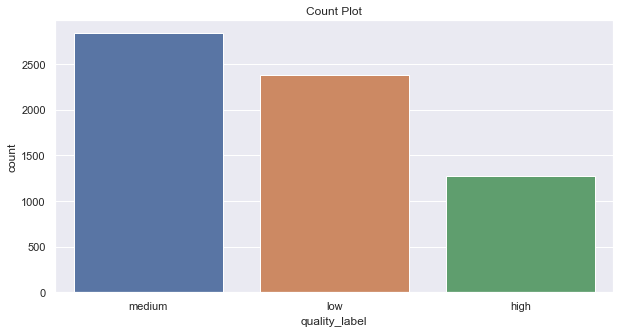

In [5]:
f, axes = plt.subplots(1, 1, figsize = (10, 5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="quality_label", data = df).set_title('Count Plot')

In [6]:
def rstr(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'skewness', 'kurtosis']
    str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis], axis = 1)
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [7]:
rstr(df)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,skewness,kurtosis
type,object,6497,2,0,0.000000,NaN,NaN
fixed acidity,float64,6487,107,10,0.153917,1.722805,5.057727
volatile acidity,float64,6489,188,8,0.123134,1.495512,2.827081
citric acid,float64,6494,90,3,0.046175,0.473032,2.401582
residual sugar,float64,6495,317,2,0.030783,1.435000,4.358134
chlorides,float64,6495,215,2,0.030783,5.399849,50.894874
free sulfur dioxide,float64,6497,135,0,0.000000,1.220066,7.906238
total sulfur dioxide,float64,6497,276,0,0.000000,-0.001177,-0.371664
density,float64,6497,998,0,0.000000,0.503602,6.606067
pH,float64,6488,109,9,0.138525,0.386966,0.370068


# Data Cleaning:

## Handling Missing Values
* There're several missing values spotted.
* For each numerical variable, we used **sorted mean from SimpleImputer** to fill in the missing value.

In [8]:
categorical_columns = df.select_dtypes('object').columns
numeric_columns     = df.select_dtypes('number').columns

#create two DataFrames, one for each data type
df_numeric     = df[numeric_columns]
df_categorical = df[categorical_columns]

#Apply imputer to numeric columns
imp = SimpleImputer(missing_values = np.nan, strategy='mean')
df_numeric = pd.DataFrame(imp.fit_transform(df_numeric), 
                          columns = df_numeric.columns) 

#We don't need for categorical
#Join the two masked dataframes back together
df = pd.concat([df_numeric, df_categorical], axis = 1)

## Handling Highly Skewed Data
* Box-Cox transformation is one of the ways to transform **highly skewed** or non-normal variables to normal.  

In [9]:
# Do for all
numeric_features = list(numeric_columns)
skewed_features = df[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} highly skewed numerical features to be box-cox transformed".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    df[feat], l_opt[feat] = boxcox((df[feat]+1))

skewed_features2 = df[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'skew_new' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['skew'], ascending=False))

There are 6 highly skewed numerical features to be box-cox transformed


,skew,skew_new
chlorides,5.399433,0.188574
sulphates,1.798605,0.009936
fixed acidity,1.723733,-0.063260
volatile acidity,1.496087,0.112905
residual sugar,1.434889,0.136183
free sulfur dioxide,1.219784,-0.036864


# Histogram of Wine Type/Quality

* The dataset is imbalanced where we have **more samples of white wine than red**.
* Nevertheless, we have more normal quality in either type of wine.  

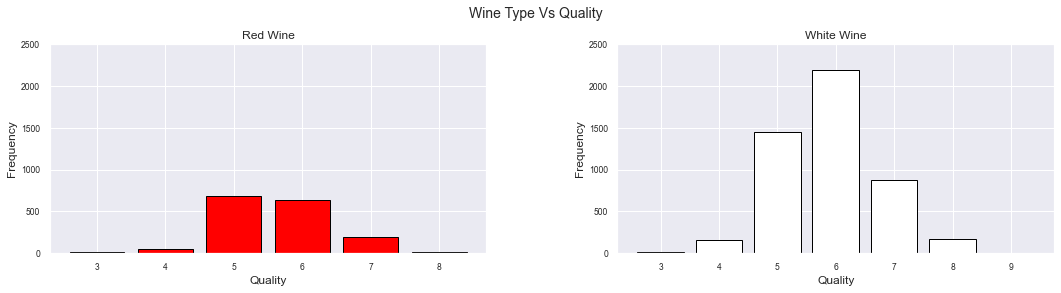

In [10]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

for i in range(0, 1 + 1, 1):
    title_list = ['Red Wine', 'White Wine']
    type_list = ['red', 'white']
    ax = fig.add_subplot(1, 2, i + 1)
    ax.set_title(title_list[i])
    ax.set_xlabel("Quality")
    ax.set_ylabel("Frequency") 
    rw_q = df.quality[df.type == type_list[i]].value_counts()
    rw_q = (list(rw_q.index), list(rw_q.values))
    ax.set_ylim([0, 2500])
    ax.tick_params(axis='both', which='major', labelsize=8.5)
    bar1 = ax.bar(rw_q[0], rw_q[1], color = type_list[i], edgecolor='black', linewidth=1)


# Further Understanding of Physicochemical Variable

* Let's have a quick glance of numerical statistics of:
    - Red/White wines splits
    - Quality Type splits
 
## Summary

### Fixed  Acidity:

* Reference: https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity  
* The predominant fixed acids found in wines are tartaric, malic, citric, and succinic. 

### Volatile  Acidity:

* Reference: https://waterhouse.ucdavis.edu/whats-in-wine/volatile-acidity 
* Volatile acidity refers to the steam distillable acids present in wine, primarily acetic acid but also lactic, formic, butyric, and propionic acids. 
* The amount of volatile acidity found in sound grapes is negligible.  It is a byproduct of microbial metabolism.
* Excess of volatile acids are undesirable and lead to unpleasant flavor. 

### Citric  Acid:
* This is one of the fixed acids which gives a wine its freshness. 
* Usually most of it is consumed during the fermentation process and sometimes it is added separately to give the wine more freshness.  

### Residual Sugar/Sweetness:
* It's the natural sugar from grapes which remains after the fermentation process stops.  

### Chlorides:
* It's the major contributor to **saltiness** in wine.
* **Highly depending on origin**
    - Reference: https://www.scielo.br/scielo.php?pid=S0101-20612015000100095&script=sci_arttext&tlng=en.
    - Australia and Argentina presented the highest levels of chloride 
    - Syrah variety presented the highest concentration of such ion.

### Sulfur dioxide:
 * This is mainly added to kill harmful bacteria and preserve quality and freshness. 
 * There are usually legal limits for sulfur levels in wines and excess of it can even kill good yeast and give out undesirable odour.
 
### Density:
 * It is a comparison of the weight of a specific volume of wine to an equivalent volume of water. 
 
### pH:
* Also known as the potential of hydrogen.
* A numeric scale to specify the acidity or basicity the wine. 
* With a pH less than 7 are acidic, while solutions with a pH greater than 7 are basic(alkaline). With a pH of 7, pure water is neutral. 
* Most wines have a pH between 2.9 and 3.9 and are therefore acidic.

### Alcohol 

* It is formed as a result of yeast converting sugar during the fermentation process. 
* The percentage of alcohol can vary from wine to wine. 
* It is interpreted  using many **different taste receptors** which is why it can taste differently, such as:
    - Bitter, sweet, spicy, and oily all at once. 
* Your genetics actually plays a role in how bitter or sweet alcohol tastes. 
* Alcohol Characteristics:
    - Wines with higher alcohol tend to taste bolder and more oily
    - Wines with lower alcohol tend to taste lighter-bodied

In [11]:
subset_attributes = df.columns
df_red = np.round(df.loc[df.type == 'red', subset_attributes].describe(), 2)
df_white = np.round(df.loc[df.type == 'white', subset_attributes].describe(), 2)
pd.concat([df_red, df_white], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1599.0   0.59   0.00  0.57   0.59   0.59   
volatile acidity                  1599.0   0.20   0.02  0.09   0.18   0.21   
citric acid                       1599.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1599.0   0.94   0.14  0.56   0.86   0.92   
chlorides                         1599.0   0.04   0.00  0.01   0.03   0.04   
free sulfur dioxide               1599.0   5.22   2.03  0.81   3.38   5.18   
total sulfur dioxide              1599.0  46.47  32.90  6.00  22.00  38.00   
density                           1599.0   1.00   0.00  0.99   1.00   1.00   
pH                                1599.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1599.0   0.25   0.02  0.19   0.24   0.25   
alcohol                           1599.0  10.42   1.07  8.40   9.50  10.20   
quality                           1599.0   5.64   0.81  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          0.60    0.61                4898.0    0.59   0.00   
volatile acidity       0.22    0.25                4898.0    0.15   0.03   
citric acid            0.42    1.00                4898.0    0.33   0.12   
residual sugar         0.99    1.63                4898.0    1.18   0.35   
chlorides              0.04    0.04                4898.0    0.03   0.00   
free sulfur dioxide    6.53   12.59                4898.0    8.39   2.26   
total sulfur dioxide  62.00  289.00                4898.0  138.36  42.50   
density                1.00    1.00                4898.0    0.99   0.00   
pH                     3.40    4.01                4898.0    3.19   0.15   
sulphates              0.26    0.31                4898.0    0.23   0.02   
alcohol               11.10   14.90                4898.0   10.51   1.23   
quality                6.00    8.00                4898.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         0.56    0.59    0.59    0.59    0.60  
volatile acidity      0.07    0.13    0.15    0.17    0.24  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.43    0.81    1.27    1.50    1.95  
chlorides             0.01    0.02    0.03    0.03    0.04  
free sulfur dioxide   1.41    6.87    8.51    9.99   24.87  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.15    0.21    0.23    0.24    0.29  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00

# From above:

* Red wine is more acidic than white, by referring to **acidity and pH**.
* Red wine has about twice chlorides than white.
* Alcohol content and quality for both is similiar
* The citric acid is more present in white than red wines.

In [12]:
pd.options.display.max_columns = 30
df_low = round(df[df['quality_label'] == 'low'][subset_attributes].describe(),2).T
df_low = pd.DataFrame(df_low["mean"])
df_medium = round(df[df['quality_label'] == 'medium'][subset_attributes].describe(),2).T
df_medium = pd.DataFrame(df_medium["mean"])
df_high = round(df[df['quality_label'] == 'high'][subset_attributes].describe(),2).T
df_high = pd.DataFrame(df_high["mean"])
pd.concat([df_low, df_medium, df_high], 
          axis=1, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine'])

,Low Quality Wine,Medium Quality Wine,High Quality Wine
,mean,mean,mean
fixed acidity,0.59,0.59,0.59
volatile acidity,0.18,0.16,0.15
citric acid,0.30,0.32,0.33
residual sugar,1.13,1.13,1.10
chlorides,0.03,0.03,0.03
free sulfur dioxide,7.36,7.74,7.78
total sulfur dioxide,119.28,115.41,109.89
density,1.00,0.99,0.99
pH,3.21,3.22,3.23


# From mean statistic above, better wine should have:

* More:
    - Alcohol content, free sulfur dioxide.
* Less:
    - Acidity, total sulfur dioxide.

# Correlation Matrix

* We could roughly understand that model weights higher alcohol content as a measure of better quality of wine.
* Proabably volatile acidity as well.

<AxesSubplot:title={'center':'Correlation Matrix'}>

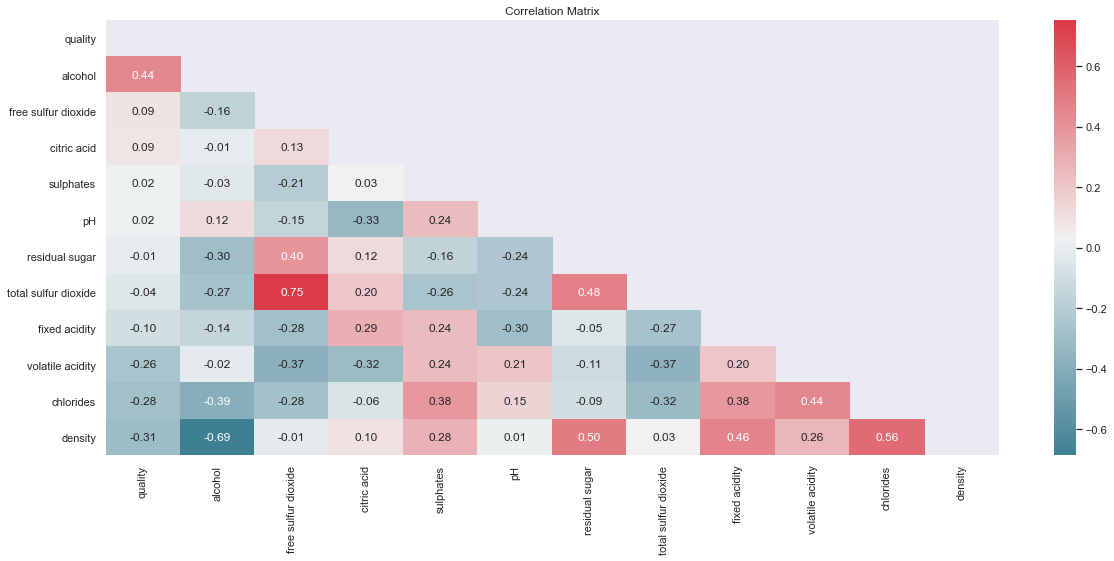

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
corr = df.corr()
ax.set_title("Correlation Matrix")
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, 
            fmt=".2f", mask=dropSelf, ax = ax)

# Violinplot of possible features

* High quality of wine has overall **higher alcohol content and less volatile acidity**.

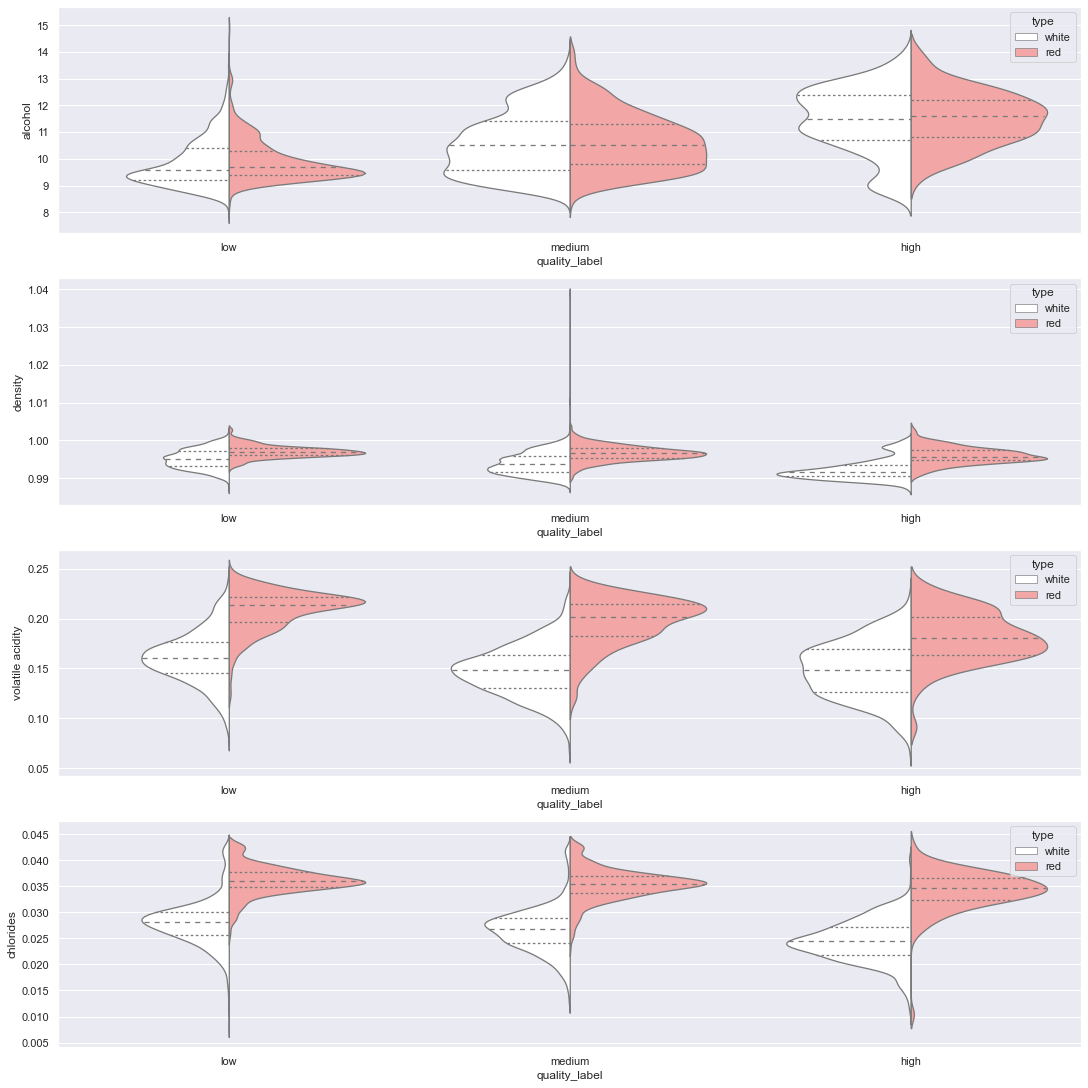

In [14]:
f, axes = plt.subplots(nrows = 4, figsize = (15, 15), constrained_layout=True)
fig.subplots_adjust(top=0.85, wspace=1)

for i in range(0, 4, 1):
    title_list = ['Wine Type - Quality - Alcohol', 'Wine Type - Quality - Density', 
                  'Wine Type - Quality - Volatile Acidity', 'Wine Type - Quality - Chlorides']
    y_list = ['alcohol', 'density', 'volatile acidity', 'chlorides']

    sns.violinplot(x = 'quality_label', y = y_list[i], hue='type', 
                   data = df, split=True, inner='quart', linewidth=1.3,
                   palette={'red': '#FF9999', 'white': 'white'}, ax = axes[i], order=['low', 'medium', 'high'])

# Machine Learning Algorithm:

* Finally, we come to a step to checkout **machine learning model** to nicely predict the quality of wines.
* We tested on:
    - Logistic regression
    - Linear Discrimant Analysis
    - K Nearest Neighbor 
    - Decision Tree (CART)
    - Bagging method: Random Forest
    - Boosting method: AdaBoost and XGBoost
    - Support Vector Classifier

In [15]:
# The target variable is 'quality'.
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 
                 'residual sugar','chlorides', 'free sulfur dioxide', 
                 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']

# Label Encoder for color of wine (Red and White wine)
class_tp = LabelEncoder()
df['color'] =  class_tp.fit_transform(df.type.values) # 1 - White; 0 - Red

# Manual Label Encoder for quality_label_class of wine (Low, medium, high quality for ease reference)
class_ql = {'low':0, 'medium': 1, 'high': 2}
df['quality_label_class']= df.quality_label.map({'low':0, 'medium': 1, 'high': 2})

y_ql = df.quality_label.map(class_ql)

y = df['quality_label_class']
X = df[feature_names]
# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size = 0.1)

In [16]:
#Prepare the model
models = []
#models.append(('Log-Reg', LogisticRegression(multi_class='multinomial')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('XGB', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, max_depth=50)))
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('DT', DecisionTreeClassifier(max_depth = 50))) #Inludes pruning at 5
models.append(('RF', RandomForestClassifier(max_depth = 50, random_state=0, n_estimators=10)))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVC', SVC()))

#Evaluate each model
results = []
names = []
for name, model, in models:
    kfold = StratifiedKFold(n_splits = 10)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LDA: 0.585771 (0.022602)
XGB: 0.713185 (0.014324)
KNN: 0.538918 (0.021302)
DT: 0.655551 (0.019864)
RF: 0.694888 (0.019973)
ADA: 0.575848 (0.021059)
SVC: 0.452366 (0.012195)


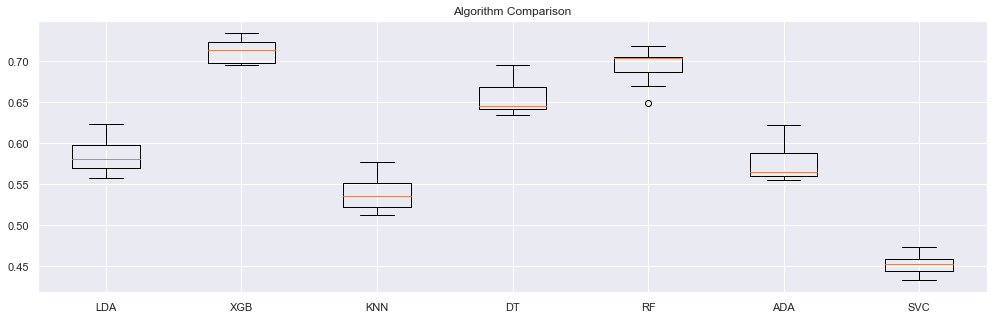

In [17]:
# Compare Algorithms
plt.figure(figsize=(17,5))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

# XGBoost

* Skipped grid search for hyperparameters tuning.

In [18]:
# Make predictions on validation dataset
# The target variable is 'quality'.
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 
                 'residual sugar','chlorides', 'free sulfur dioxide', 
                 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol', 'color']
y = df['quality_label_class']
X = df[feature_names]

# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size = 0.1)
model = XGBClassifier(learning_rate = 0.1, n_estimators = 50, max_depth = 50,
                      objective= 'multi:softprob', eval_metric='mlogloss', use_label_encoder=False,
                     seed= 100)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate predictions
print('Accuracy of XBG Classifier Model on test set: {:.2%}'
     .format(accuracy_score(y_test, predictions)))
print('*' * 60)
print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))
print('*' * 60)
print('Classification Report')
print(classification_report(y_test, predictions))

Accuracy of XBG Classifier Model on test set: 74.46%
************************************************************
Confusion Matrix
[[181  40   0]
 [ 52 200  33]
 [  4  37 103]]
************************************************************
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       221
           1       0.72      0.70      0.71       285
           2       0.76      0.72      0.74       144

    accuracy                           0.74       650
   macro avg       0.75      0.75      0.75       650
weighted avg       0.74      0.74      0.74       650



# SMOTE Technique (Over-Sampling):
* SMOTE stands for Synthetic Minority Over-sampling Technique.
* SMOTE creates new synthetic points in order to have an **equal balance** of the classes.

## Outcomes:
* Recall score for minority class (high quality) has increased.

In [19]:
# Make predictions on validation dataset
# The target variable is 'quality'.

from imblearn.over_sampling import SMOTE

feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 
                 'residual sugar','chlorides', 'free sulfur dioxide', 
                 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol', 'color']
y = df['quality_label_class']
X = df[feature_names]

# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size = 0.1)

# SMOTE
smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
model = XGBClassifier(learning_rate = 0.1, n_estimators = 50, max_depth = 50,
                      objective= 'multi:softprob', eval_metric='mlogloss', use_label_encoder=False,
                     seed= 100)

model.fit(X_train_oversampled, y_train_oversampled)
predictions = model.predict(X_test)

# Evaluate predictions
print('Accuracy of XBG Classifier Model on test set: {:.2%}'
     .format(accuracy_score(y_test, predictions)))
print('*' * 60)
print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))
print('*' * 60)
print('Classification Report')
print(classification_report(y_test, predictions))

Accuracy of XBG Classifier Model on test set: 73.38%
************************************************************
Confusion Matrix
[[181  50   5]
 [ 48 177  42]
 [  4  24 119]]
************************************************************
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       236
           1       0.71      0.66      0.68       267
           2       0.72      0.81      0.76       147

    accuracy                           0.73       650
   macro avg       0.73      0.75      0.74       650
weighted avg       0.73      0.73      0.73       650



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

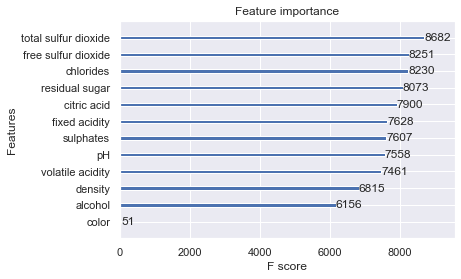

In [20]:
model.get_booster().feature_names = feature_names
plot_importance(model)

# Finally, save the model

* Use **Pickle** package to save the trained model.
* To re-load the model, simply loaded_model = pickle.load(open(filename, 'rb'))

In [21]:
# save the model to disk
import pickle
filename = 'wine_quality.pkl'
pickle.dump(model, open(filename, 'wb'))